# Calculation of the duration time of each phase of cell cycle based on total RNA velocity

Here you will learn how to calculate the duration time of each phase of the cell cycle based on total RNA velocity. We calculate total RNA velocity based on the Storm CSP model and Dynamo twostep and compare the results of cell cycle time between the two methods. 

In [1]:
#!/usr/bin/env python 
# -*- coding:utf-8 -*-

import warnings

import numpy as np

warnings.filterwarnings('ignore')
import dynamo as dyn
from tqdm import tqdm
from collections import Counter

## Load and preprocess the data

In [2]:
filename = './data/rpe1.h5ad'

rpe1 = dyn.read(filename)

dyn.convert2float(rpe1, ['Cell_cycle_possition', 'Cell_cycle_relativePos'])

rpe1.obs.exp_type.value_counts()

rpe1[rpe1.obs.exp_type == 'Chase', :].obs.time.value_counts()

rpe1[rpe1.obs.exp_type == 'Pulse', :].obs.time.value_counts()

rpe1_kinetics = rpe1[rpe1.obs.exp_type == 'Pulse', :]
rpe1_kinetics.obs['time'] = rpe1_kinetics.obs['time'].astype(str)
rpe1_kinetics.obs.loc[rpe1_kinetics.obs['time'] == 'dmso', 'time'] = -1
rpe1_kinetics.obs['time'] = rpe1_kinetics.obs['time'].astype(float)
rpe1_kinetics = rpe1_kinetics[rpe1_kinetics.obs.time != -1, :]


rpe1_kinetics.layers['new'], rpe1_kinetics.layers['total'] = rpe1_kinetics.layers['ul'] + rpe1_kinetics.layers['sl'], \
                                                             rpe1_kinetics.layers['su'] + rpe1_kinetics.layers['sl'] + \
                                                             rpe1_kinetics.layers['uu'] + rpe1_kinetics.layers['ul']

del rpe1_kinetics.layers['uu'], rpe1_kinetics.layers['ul'], rpe1_kinetics.layers['su'], rpe1_kinetics.layers['sl']


rpe1_kinetics.obs.time = rpe1_kinetics.obs.time.astype('float')
rpe1_kinetics.obs.time = rpe1_kinetics.obs.time / 60  # convert minutes to hours

## Calculate total RNA velocity

Calculate total RNA velocity based on CSP model:

|-----> keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: keep_filtered_cells_key=False
|-----> apply Monocole recipe to adata...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.
[ Future queries will be cached in "/home/pqw/pythonProject3/mygene_cache.sqlite" ]
querying 1-1000...done. [ from cache ]
querying 1001-2000...done. [ from cache ]
querying 2001-3000...done. [ from cache ]
querying 3001-4000...done. [ from cache ]
querying 4001-5000...done. [ from cache ]
querying 5001-6000...done. [ from cache ]
querying 6001-7000...done. [ from cache ]
querying 7001-8000...done. [ from cache ]
querying 8001-9000...done. [ from cache ]
querying 9001-10000...done. [ from cache ]
querying 10001-11000...done. [ from cache ]
querying 11001-11848...done. [ from cache 

Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:01, 572.44it/s]
Infer parameters via maximum likelihood estimation based on the CSP model: 86it [00:00, 420.09it/s]

Inequality constraints incompatible


Infer parameters via maximum likelihood estimation based on the CSP model: 642it [00:01, 435.00it/s]

Inequality constraints incompatible


Infer parameters via maximum likelihood estimation based on the CSP model: 794it [00:01, 483.93it/s]

Inequality constraints incompatible


Infer parameters via maximum likelihood estimation based on the CSP model: 1000it [00:02, 453.97it/s]


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [13.4304s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|

<Figure size 600x400 with 0 Axes>

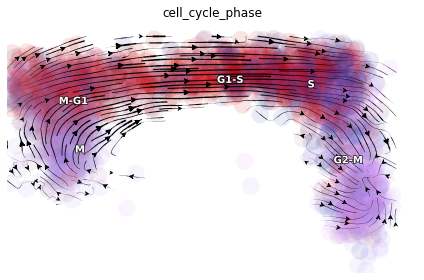

In [3]:
# CSP
rpe1_kinetics_csp = rpe1_kinetics.copy()
dyn.tl.recipe_kin_data(adata=rpe1_kinetics_csp,
                       keep_filtered_genes=True,
                       keep_raw_layers=True,
                       del_2nd_moments=False,
                       tkey='time',
                       n_top_genes=1000,
                       est_method='CSP4ML_CSP',
                       )

rpe1_kinetics_csp.obsm['X_RFP_GFP'] = rpe1_kinetics_csp.obs.loc[:,
                                  ['RFP_log10_corrected', 'GFP_log10_corrected']].values.astype('float')

dyn.tl.reduceDimension(rpe1_kinetics_csp, reduction_method='umap')
dyn.tl.cell_velocities(rpe1_kinetics_csp, enforce=True, vkey='velocity_T', ekey='M_t', basis='RFP_GFP')
dyn.pl.streamline_plot(rpe1_kinetics_csp, color=['cell_cycle_phase'], basis='RFP_GFP')

Calculate total RNA velocity based on Dynamo twostep:

|-----> keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: keep_filtered_cells_key=False
|-----> apply Monocole recipe to adata...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.
[ Future queries will be cached in "/home/pqw/pythonProject3/mygene_cache.sqlite" ]
querying 1-1000...done. [ from cache ]
querying 1001-2000...done. [ from cache ]
querying 2001-3000...done. [ from cache ]
querying 3001-4000...done. [ from cache ]
querying 4001-5000...done. [ from cache ]
querying 5001-6000...done. [ from cache ]
querying 6001-7000...done. [ from cache ]
querying 7001-8000...done. [ from cache ]
querying 8001-9000...done. [ from cache ]
querying 9001-10000...done. [ from cache ]
querying 10001-11000...done. [ from cache ]
querying 11001-11848...done. [ from cache 

Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:01, 580.58it/s]


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [11.3488s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|

<Figure size 600x400 with 0 Axes>

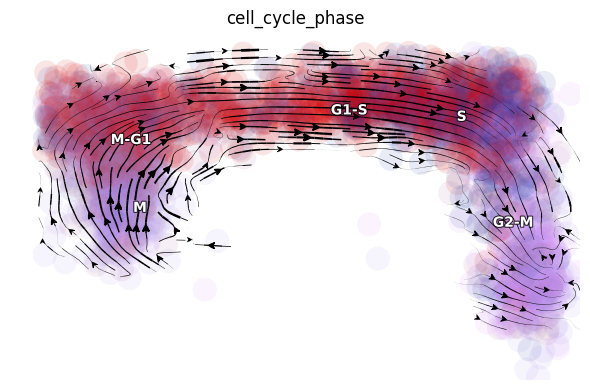

In [4]:
rpe1_kinetics_dynamo = rpe1_kinetics.copy()
dyn.tl.recipe_kin_data(adata=rpe1_kinetics_dynamo,
                       keep_filtered_genes=True,
                       keep_raw_layers=True,
                       del_2nd_moments=False,
                       tkey='time',
                       n_top_genes=1000,
                       est_method='twostep',
                       )

rpe1_kinetics_dynamo.obsm['X_RFP_GFP'] = rpe1_kinetics_dynamo.obs.loc[:,
                                  ['RFP_log10_corrected', 'GFP_log10_corrected']].values.astype('float')

dyn.tl.reduceDimension(rpe1_kinetics_dynamo, reduction_method='umap')
dyn.tl.cell_velocities(rpe1_kinetics_dynamo, enforce=True, vkey='velocity_T', ekey='M_t', basis='RFP_GFP')
dyn.pl.streamline_plot(rpe1_kinetics_dynamo, color=['cell_cycle_phase'], basis='RFP_GFP')

## Calculate cell cycle time based on total RNA velocity

In [5]:
# The function to calculate cell cycle time based on total RNA velocity (see "Method" section)
def get_cell_cycle_time(adata, X, V, dt=0.01):
    from sklearn.neighbors import NearestNeighbors

    Cell_cycle_relativePos = adata.obs['Cell_cycle_relativePos'].values.copy()
    cell_cycle_phase = adata.obs['cell_cycle_phase'].astype('str').values.copy()
    init_cells_id = np.argpartition(Cell_cycle_relativePos, 300)[:300]

    M_time = 0
    M_G1_time = 0
    G1_S_time = 0
    S_time = 0
    G2_M_time = 0


    nbrs = NearestNeighbors(n_neighbors=300, metric='euclidean').fit(X)

    x_i = np.mean(X[init_cells_id, :], axis=0)
    v_i = np.mean(V[init_cells_id, :], axis=0)
    state = list(cell_cycle_phase[init_cells_id])
    state_next_count = Counter(state)
    state_i = max(state_next_count, key=state_next_count.get)

    def search_next_cell(x_i, v_i, dt):
        x_plus_v_i = x_i + v_i * dt
        next_id = nbrs.kneighbors(x_plus_v_i.reshape(1, -1), return_distance=False)
        return next_id[0], x_plus_v_i

    M_time, M_G1_time, G1_S_time, S_time, G2_M_time = 0.0, 0.0, 0.0, 0.0, 0.0
    
    while True:
        next_id, x_next = search_next_cell(x_i, v_i, dt)
        v_next = np.mean(V[next_id, :], axis=0)
        state_next = list(cell_cycle_phase[next_id])
        state_next_count = Counter(state_next)
        state_i = max(state_next_count, key=state_next_count.get)
        x_i, v_i = x_next, v_next
        
        if state_i == 'M':
            M_time = M_time + dt

        if state_i == 'M-G1':
            M_G1_time = M_G1_time + dt

        if state_i == 'G1-S':
            G1_S_time = G1_S_time + dt

        if state_i == 'S':
            S_time = S_time + dt

        if state_i == 'G2-M':
            G2_M_time = G2_M_time + dt

        if np.mean(Cell_cycle_relativePos[next_id]) > np.percentile(Cell_cycle_relativePos, 88):
            break

    return M_time, M_G1_time, G1_S_time, S_time, G2_M_time

Calculate cell cycle time based on CSP model:

In [6]:
X_RFP_GFP_csp = rpe1_kinetics_csp.obsm['X_RFP_GFP']
V_RFP_GFP_csp = rpe1_kinetics_csp.obsm['velocity_RFP_GFP']

M_time_csp, M_G1_time_csp, G1_S_time_csp, S_time_csp, G2_M_time_csp = get_cell_cycle_time(
    rpe1_kinetics_csp, X_RFP_GFP_csp, V_RFP_GFP_csp)

Calculate cell cycle time based on Dynamo twostep:

In [8]:
X_RFP_GFP_dynamo = rpe1_kinetics_dynamo.obsm['X_RFP_GFP']
V_RFP_GFP_dynamo = rpe1_kinetics_dynamo.obsm['velocity_RFP_GFP']

M_time_dynamo, M_G1_time_dynamo, G1_S_time_dynamo, S_time_dynamo, G2_M_time_dynamo = get_cell_cycle_time(
    rpe1_kinetics_dynamo, X_RFP_GFP_dynamo, V_RFP_GFP_dynamo)

## Visualize the comparison of cell cycle time between the two methods

In [9]:
cell_cycle_time = np.zeros((5,2))
cell_cycle_time[:, 0] = M_time_csp, M_G1_time_csp, G1_S_time_csp, S_time_csp, G2_M_time_csp
cell_cycle_time[:, 1] = M_time_dynamo, M_G1_time_dynamo, G1_S_time_dynamo, S_time_dynamo, G2_M_time_dynamo

Change the matplotlib settings for better visualization:

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '6'
figsize = (1.78,1.55)
dpi = 300

Visualize:

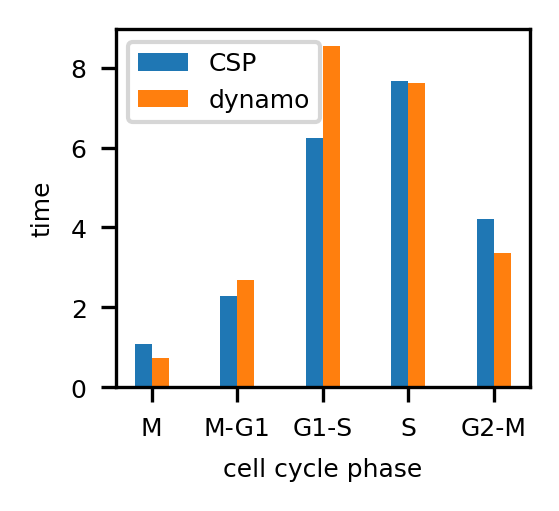

In [11]:
fig = plt.figure(1, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
x_labels = ['M', 'M-G1', 'G1-S', 'S', 'G2-M']
groups = len(x_labels)
width = 0.25
ind = np.linspace(0, groups, groups)

# Set the ticks on x-axis
ax.set_xticks(ind)
ax.set_xticklabels(x_labels)
# labels
ax.set_xlabel('cell cycle phase')
ax.set_ylabel('time')


ax.bar(ind - 0.5 * width, cell_cycle_time[:, 0], width, label='CSP')
ax.bar(ind + 0.5 * width, cell_cycle_time[:, 1], width, label='dynamo')
plt.legend()
# plt.savefig('cell_cycle_time.pdf', bbox_inches="tight")
plt.show()